# Masterskaya_27DS+_(STD)_Мэтчинг

**Краткое описание проекта** <br>
Задача<br>
- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике accuracy@5
- *деплой: разработать REST API сервис, который по предложенным данным будем предлагать несколько похожих товаров.

Описание имеющихся данных:<br>
* base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
* train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).
* validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv
* validation_answer.csv - правильные ответы к предыдущему файлу.

**Цель исследования:** <br>
Разработать алгоритм, который на основе обучающего набора данных (train.csv) и валидационного набора данных (validation.csv) предложит несколько вариантов наиболее похожих товаров из базы данных (base.csv) для каждого товара из валидационного набора. Это позволит создать систему рекомендаций товаров, способную предлагать пользователям товары, аналогичные тем, которые они уже просматривали или покупали.

**Контекст исследования:** <br>
В современном мире, где потребители сталкиваются с огромным выбором товаров, система рекомендаций играет ключевую роль в удовлетворении потребностей пользователей. Она помогает компаниям увеличить продажи, улучшить пользовательский опыт и увеличить лояльность клиентов. В данном исследовании используется набор данных, содержащий информацию о товарах и их признаках, чтобы разработать алгоритм, способный предсказывать наиболее подходящие товары на основе входных данных.

**План исследования:** <br>
1. **Установка и импорт необходимых библиотек**: Начнем с установки и импорта необходимых библиотек для работы с данными и разработки алгоритма.
2. **Выгрузка данных**: Загрузим обучающий, валидационный и базовый наборы данных из соответствующих CSV-файлов.
3. **EDA (Exploratory Data Analysis)**: Проведем исследование данных, включая построение гистограмм для визуализации распределения признаков, проверку корреляций между признаками и определение признаков с ненормальным распределением.
4. **Удаление столбцов с ненормальным распределением**: На основе EDA удалим признаки с ненормальным распределением, которые могут негативно влиять на качество модели.
5. **Преобразование данных**: Применим стандартизацию данных для всех трех наборов данных, чтобы обеспечить согласованность масштаба признаков.
6. **Создание индекса**: Используя библиотеку FAISS, создадим индекс для быстрого поиска ближайших соседей в базовом наборе данных.
7. **Обучение и тестирование модели**: Обучим модель на обучающем наборе данных и оценим ее качество на валидационном наборе данных, используя метрику accuracy@5.
8. **Деплой**: Разработаем REST API сервис, который будет использовать обученную модель для предложения наиболее подходящих товаров на основе входных данных.

Этот план исследования позволит достичь поставленной цели разработки эффективной системы рекомендаций товаров, способной предлагать пользователям наиболее подходящие товары на основе их интересов и предыдущих покупок.

## 1 Установка и импорт необходимых библиотек

In [4]:
import os
import sys

# Перенаправление вывода stdout
original_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')

# Установка пакета faiss-cpu
!conda install -c pytorch faiss-cpu -y

# Восстановление stdout
sys.stdout = original_stdout

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import faiss
from flask import Flask, request, jsonify
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
from concurrent.futures import ThreadPoolExecutor

In [5]:
# Дополнительные библиотеки
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None) # увеличиваем максимальное количество отображающихся столбцов
pd.set_option('display.float_format', '{:.2f}'.format) # числа в датасетах отражались с 2 знаками после запятой

## 2 Загрузка данных

In [6]:
base_df = pd.read_csv('/kaggle/input/product-matching-data/base.csv')
train_df = pd.read_csv('/kaggle/input/product-matching-data/train.csv')
validation_df = pd.read_csv('/kaggle/input/product-matching-data/validation.csv')
validation_answer_df = pd.read_csv('/kaggle/input/product-matching-data/validation_answer.csv')

### 2.1 Посмотрим загруженные данные

In [7]:
print('Описание данных base_df')
display(base_df.head())
display(base_df.info())
display(base_df.describe())
print('')
print('Описание данных train_df')
display(train_df.head())
display(train_df.info())
display(train_df.describe())
print('')
print('Описание данных validation_df')
display(validation_df.head())
display(validation_df.info())
display(validation_df.describe())
print('')
print('Описание данных validation_answer_df')
display(validation_answer_df.head())
display(validation_answer_df.info())
display(validation_answer_df.describe())
print('все данные загружены')

Описание данных base_df


,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.08,11.15,-64.43,-118.88,216.48,-104.70,-469.07,44.35,120.92,181.45,-124.06,-32.46,-57.42,36.21,182.72,-28.07,-5.21,-1.73,-91.09,-79.47,-103.94,1507.23,-32.59,51.41,-51.91,813.77,-41.56,8.42,-129.98,148.77,-10.07,-143.01,79.85,-537.18,2.77,111.52,4.26,-153.34,-123.63,-39.71,-12.77,-4.17,-152.97,75.91,-57.47,17.27,-98.87,-138.07,91.00,-170.70,-50.02,59.79,78.11,-89.38,89.41,79.81,-129.51,-44.66,-80.44,5.15,-64.52,-138.78,-42.81,38.80,-151.76,-74.39,63.67,-4.70,92.93,115.27,-112.76,-60.83
1,1-base,-34.56,13.33,-69.79,-166.53,57.68,-86.10,-85.08,-35.64,119.72,195.23,-141.30,-126.77,-68.85,8.31,143.08,8.78,15.16,48.25,-244.95,-80.28,-81.79,429.88,-5.94,70.14,66.58,813.77,3.21,17.16,-39.42,148.16,-7.58,-174.37,101.22,-303.94,16.91,53.39,33.45,-148.55,-110.34,-33.28,-8.69,13.65,-91.23,38.45,-31.95,62.48,-166.47,-189.01,-56.73,-30.03,59.17,-56.71,63.54,-121.32,97.43,74.83,-138.78,58.89,-71.60,-251.95,11.39,-148.57,-117.77,41.10,-157.83,-94.45,68.20,24.35,179.94,116.83,-84.89,-59.52
2,2-base,-54.23,6.38,-29.21,-133.41,150.90,-99.44,52.55,62.38,128.95,164.38,-140.82,-22.49,-51.67,2.52,140.59,-22.04,-7.13,-5.18,-111.71,-79.03,-82.45,1507.23,-0.42,84.11,63.34,813.77,-105.21,18.84,-94.79,151.39,-21.48,-144.85,48.50,-780.45,64.77,79.78,-13.39,-150.06,-118.76,-40.90,-15.22,-1.86,-93.82,98.75,-46.75,65.93,-10.29,-125.32,21.05,-22.64,68.92,-54.90,66.34,-142.93,83.03,69.98,-123.73,65.32,-114.04,-529.40,-101.58,-134.66,-76.40,46.01,-207.14,127.33,65.57,66.33,81.07,116.59,-1074.46,-32.53
3,3-base,-87.52,4.04,-87.80,-185.07,76.37,-58.99,-383.18,-33.61,122.03,136.23,-108.47,-104.54,-82.39,-79.99,113.60,-39.00,-4.79,8.33,-124.86,-79.11,-107.94,1479.17,-125.27,24.66,-16.92,813.77,-182.68,14.72,-62.93,151.20,10.61,-134.93,58.78,-529.30,43.67,92.81,-38.94,-145.05,-124.30,-36.88,-17.74,10.54,-124.58,121.91,-17.32,105.22,-94.38,-63.77,29.22,-26.42,5.87,64.06,63.51,-112.26,80.93,72.64,-137.31,7.91,-62.19,-540.32,-89.59,-149.33,-70.65,-6.36,-147.20,-37.69,66.20,-20.57,137.21,117.47,-1074.46,-72.92
4,4-base,-72.74,6.52,43.67,-140.61,5.82,-112.07,-397.71,45.18,122.17,112.12,-110.34,-38.98,-50.23,-26.69,135.27,-7.51,8.92,111.58,-130.83,-79.32,-57.84,1262.92,19.23,59.81,76.16,312.70,-76.73,21.30,-24.07,167.39,-44.06,-148.13,98.04,-657.52,96.36,71.06,-36.56,-135.37,-123.71,-44.74,-10.86,8.35,-168.33,215.93,-32.98,66.86,30.84,-211.54,57.70,-67.82,-29.39,-34.12,54.71,-26.03,90.67,58.09,-134.78,77.62,-176.62,-529.76,-100.57,-125.32,-57.20,56.64,-159.35,85.94,66.77,-2.51,65.32,135.05,-1074.46,0.32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float64
 2   1       float64
 3   2       float64
 4   3       float64
 5   4       float64
 6   5       float64
 7   6       float64
 8   7       float64
 9   8       float64
 10  9       float64
 11  10      float64
 12  11      float64
 13  12      float64
 14  13      float64
 15  14      float64
 16  15      float64
 17  16      float64
 18  17      float64
 19  18      float64
 20  19      float64
 21  20      float64
 22  21      float64
 23  22      float64
 24  23      float64
 25  24      float64
 26  25      float64
 27  26      float64
 28  27      float64
 29  28      float64
 30  29      float64
 31  30      float64
 32  31      float64
 33  32      float64
 34  33      float64
 35  34      float64
 36  35      float64
 37  36      float64
 38  37      float64
 39  38      float64
 40  

None

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00,2918139.00
mean,-86.23,8.08,-44.58,-146.63,111.32,-71.99,-392.22,20.35,123.68,124.46,-143.14,-69.89,-41.26,7.59,148.99,-23.17,-0.94,-19.31,-137.27,-79.19,-98.25,1257.53,-6.82,56.67,26.70,727.10,-66.25,16.32,-86.37,151.73,-11.61,-144.23,87.22,-554.16,36.24,75.20,-16.49,-146.64,-118.51,-41.88,-9.48,4.05,-112.74,120.87,-39.81,58.94,-84.89,-138.47,47.93,-32.38,26.58,-21.72,67.00,-117.90,88.03,69.20,-132.91,13.23,-119.60,-316.09,-64.94,-130.67,-79.02,33.30,-154.80,14.15,67.79,23.54,74.96,115.57,-799.34,-47.79
std,24.89,4.95,38.63,19.84,46.35,28.19,271.65,64.22,6.36,64.43,41.69,51.22,38.96,36.60,33.64,13.08,20.83,52.97,46.63,0.76,28.16,399.96,51.97,34.36,38.94,205.57,61.53,4.66,48.51,10.09,28.95,34.76,27.86,260.65,39.90,21.45,25.85,9.95,13.14,19.20,8.19,5.84,56.94,46.72,14.74,32.11,63.19,57.74,45.20,58.29,58.95,51.74,13.07,54.71,4.77,11.95,7.82,51.08,55.24,210.66,62.48,9.57,30.46,28.89,41.23,98.95,1.82,55.34,61.35,21.18,385.41,41.75
min,-199.47,-13.91,-240.07,-232.67,-105.58,-211.01,-791.47,-301.86,93.15,-173.87,-343.84,-368.45,-226.09,-175.62,-15.27,-85.92,-96.37,-272.57,-351.75,-83.15,-243.73,136.82,-238.29,-88.18,-143.18,-61.98,-358.55,-8.36,-314.01,107.44,-156.73,-298.68,-34.65,-1045.31,-137.85,-21.52,-137.99,-195.42,-176.91,-132.71,-47.58,-21.58,-338.12,-87.71,-63.10,-77.25,-362.93,-418.70,-145.39,-322.81,-280.27,-264.63,6.20,-381.26,65.58,14.08,-167.06,-196.18,-359.71,-681.04,-400.79,-171.35,-220.57,-88.51,-353.90,-157.59,59.51,-233.14,-203.60,15.72,-1297.93,-226.78
25%,-103.07,4.71,-69.56,-159.91,80.51,-91.38,-629.33,-22.22,119.48,81.77,-170.32,-104.03,-66.63,-16.94,125.97,-31.77,-15.15,-55.46,-167.59,-79.68,-116.84,1088.60,-42.24,33.30,0.56,813.77,-107.85,13.26,-118.66,144.89,-30.75,-167.04,68.30,-771.30,9.35,60.91,-34.14,-153.27,-127.45,-54.79,-14.98,0.04,-151.59,88.20,-52.87,36.99,-128.20,-176.60,17.90,-69.95,-12.33,-56.28,58.46,-154.49,84.71,61.31,-138.10,-22.39,-157.43,-498.48,-106.55,-137.39,-98.76,16.99,-180.78,-71.30,66.58,-12.52,33.78,101.69,-1074.46,-75.67
50%,-86.23,8.04,-43.82,-146.78,111.87,-71.92,-422.20,20.80,123.89,123.50,-141.72,-70.23,-40.40,8.13,149.31,-22.91,-1.03,-19.80,-136.80,-79.18,-97.53,1507.23,-6.42,57.00,27.13,813.77,-66.20,16.39,-85.54,151.64,-11.19,-144.12,86.87,-529.30,35.32,74.61,-16.32,-146.72,-118.60,-42.03,-9.47,4.05,-113.06,119.90,-40.03,58.96,-85.11,-137.38,46.97,-29.17,27.51,-22.21,67.22,-117.63,88.01,69.36,-132.83,13.11,-120.46,-315.99,-63.69,-130.88,-78.49,34.72,-153.98,13.83,67.81,23.42,74.93,116.02,-1074.46,-48.59
75%,-69.26,11.47,-19.63,-133.33,142.37,-52.44,-156.67,63.92,127.97,167.22,-114.99,-35.70,-14.84,32.67,172.16,-14.34,13.37,16.59,-107.54,-78.68,-79.24,1507.23,28.23,79.66,53.09,813.77,-25.58,19.44,-53.88,158.28,8.29,-121.47,106.01,-341.78,62.86,88.87,1.22,-139.95,-109.67,-28.92,-4.01,8.07,-73.81,152.24,-25.97,81.89,-43.01,-100.10,78.53,7.65,66.00,12.82,75.90,-80.64,91.31,77.24,-127.62,48.16,-81.71,-133.61,-22.53,-124.27,-58.53,52.16,-127.34,99.67,69.03,59.76,115.88,129.55,-505.74,-19.71
max,21.52,29.9


Описание данных train_df


,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.88,17.97,-42.12,-183.94,187.52,-87.14,-347.36,38.31,109.09,30.41,-88.08,-52.70,-27.69,4.87,198.35,-30.08,-3.80,-135.81,-161.84,-78.51,-94.43,898.44,-70.14,78.42,108.03,813.77,-74.79,12.61,-183.82,149.72,-27.04,-133.21,106.42,-303.94,48.73,58.19,24.25,-151.22,-104.28,-34.49,-12.59,2.62,-120.97,149.99,-31.95,82.31,-115.83,-243.31,6.62,-132.20,68.71,-38.81,62.94,-132.65,89.19,87.04,-121.28,-6.99,-206.51,29.49,-77.03,-132.39,-105.43,70.11,-155.80,-101.97,65.90,34.46,62.64,134.76,-415.75,-25.96,675816-base
1,1-query,-87.78,6.81,-32.05,-177.26,120.80,-83.81,-94.57,-78.43,124.92,140.33,-177.61,-85.00,42.81,-57.26,96.79,-19.26,0.74,50.62,-155.27,-78.66,-92.76,353.16,-34.74,82.49,-28.45,813.77,-137.53,26.60,-136.78,153.36,48.81,-115.92,87.46,-222.29,25.12,91.89,-30.64,-136.59,-140.50,-43.45,-7.23,8.27,-117.92,149.15,-18.75,95.32,-60.09,-83.82,37.45,-23.30,74.06,-7.14,75.86,-112.05,82.86,54.07,-134.01,-26.14,-214.63,-457.85,21.46,-137.41,-40.81,4.67,-151.70,-1.64,68.17,25.10,89.97,130.59,-1035.09,-51.28,366656-base
2,2-query,-49.98,3.84,-116.12,-180.40,190.13,-50.84,26.94,-30.45,125.77,211.61,-86.35,-35.67,16.40,-80.80,137.91,-23.53,-47.26,-16.65,-194.51,-78.37,-69.32,1507.23,-52.50,-34.17,52.96,813.77,-18.02,20.95,-50.32,158.76,0.18,-183.07,99.05,-1018.47,-51.80,97.77,-10.87,-144.42,-133.82,-78.90,-17.20,4.47,-63.97,154.64,-30.21,48.53,-122.41,-112.71,53.46,-31.12,107.84,16.48,77.93,-95.62,91.46,63.12,-126.94,8.07,-195.68,-163.12,-72.83,-139.22,-52.03,78.04,-169.15,82.14,66.01,18.40,212.41,121.93,-1074.46,-22.55,1447819-base
3,3-query,-47.81,9.09,-115.40,-121.01,94.65,-109.26,-775.15,79.19,124.00,242.65,-146.52,-159.47,-13.84,-6.11,118.94,-44.59,9.56,14.44,-156.91,-78.79,-78.74,1507.23,19.96,34.83,-8.82,813.77,-125.61,17.58,-58.45,141.28,-54.96,-136.99,63.88,-1018.47,89.23,65.92,-24.08,-152.33,-91.20,-28.23,-4.77,0.16,-129.13,122.96,-30.80,123.62,-37.54,-72.14,71.24,-168.12,118.24,-18.07,37.26,-137.69,87.50,62.44,-131.26,35.69,-86.04,-379.34,-153.47,-131.20,-61.57,44.52,-145.42,93.99,64.13,106.06,83.18,118.28,-1074.46,-19.90,1472602-base
4,4-query,-79.63,14.44,-58.90,-147.05,57.13,-16.24,-321.32,45.98,125.94,103.39,-107.15,-8.80,-50.98,29.46,143.39,5.61,-45.27,9.64,-77.55,-79.07,-77.93,1507.23,16.61,116.28,33.75,813.77,-105.77,6.52,-19.81,157.69,-20.60,-146.59,78.85,-780.45,87.56,73.04,16.89,-144.66,-116.12,-19.35,-7.71,-5.39,-140.25,193.18,-53.15,79.87,-151.13,-45.06,79.80,46.76,47.68,-24.10,75.14,-207.35,93.44,51.51,-135.48,99.80,-49.16,-203.21,-127.75,-103.34,-68.77,45.03,-196.09,-117.63,66.93,42.46,77.62,92.48,-1074.46,-21.15,717819-base


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 74 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

None

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
mean,-85.33,7.66,-43.67,-146.12,111.77,-73.18,-440.62,21.23,123.07,126.12,-141.17,-69.23,-42.56,6.51,149.08,-23.94,-2.22,-12.96,-138.71,-79.16,-97.47,1297.27,-3.60,55.91,23.47,742.79,-64.97,16.37,-86.20,152.10,-13.66,-144.51,89.75,-587.55,36.47,73.11,-13.87,-146.49,-118.34,-41.13,-9.26,4.14,-104.93,122.24,-40.32,59.05,-84.05,-140.79,46.14,-34.14,29.46,-22.34,67.58,-120.05,88.19,69.54,-132.34,14.45,-120.30,-315.28,-66.38,-130.67,-81.15,36.90,-152.22,14.00,67.80,23.03,73.41,115.19,-709.76,-48.51
std,25.80,4.96,39.11,20.43,47.70,28.72,279.02,65.99,6.49,64.91,41.61,51.26,40.82,37.59,34.17,13.02,20.98,55.21,48.74,0.78,28.38,375.12,50.06,35.62,40.80,191.05,63.16,4.83,49.51,10.39,29.19,35.82,28.31,273.29,39.76,20.01,25.82,10.38,13.58,19.87,8.30,5.92,56.52,48.11,14.74,31.09,66.06,59.85,46.33,59.33,60.93,54.99,12.99,55.92,4.82,12.34,7.95,49.23,55.73,210.66,64.91,9.41,30.68,25.36,41.02,99.08,1.84,55.47,62.20,21.58,405.96,41.22
min,-186.28,-11.56,-224.90,-223.31,-93.27,-184.96,-791.47,-278.58,94.83,-142.16,-330.57,-352.41,-214.74,-145.86,8.82,-82.65,-91.66,-247.59,-326.65,-82.64,-228.81,136.87,-211.97,-87.32,-122.58,-61.80,-338.56,-6.63,-285.67,111.39,-130.44,-290.12,-25.55,-1044.14,-119.90,-11.93,-124.56,-193.92,-166.08,-123.06,-43.06,-18.98,-324.94,-67.54,-63.10,-64.79,-327.32,-365.06,-129.88,-280.37,-250.34,-236.15,18.48,-354.92,66.07,18.10,-161.19,-183.85,-330.64,-681.03,-358.46,-169.57,-210.06,-60.78,-317.83,-157.59,60.67,-203.75,-181.97,22.60,-1297.87,-209.94
25%,-103.31,4.31,-69.49,-160.03,79.47,-92.83,-738.54,-22.13,118.67,82.55,-168.60,-103.05,-69.80,-18.82,126.37,-32.38,-16.46,-49.61,-171.66,-79.66,-115.41,1248.13,-37.05,31.44,-5.05,813.77,-106.86,13.19,-119.61,145.14,-32.81,-168.54,70.43,-803.39,9.51,59.98,-30.93,-153.34,-127.60,-54.59,-14.77,0.09,-144.02,89.14,-53.81,37.83,-129.67,-181.18,14.32,-73.42,-11.03,-59.61,58.55,-157.93,84.91,61.21,-137.75,-19.54,-158.72,-497.15,-110.07,-137.07,-101.50,19.77,-178.93,-71.75,66.56,-14.14,31.69,100.59,-1074.46,-76.48
50%,-85.27,7.65,-42.83,-146.07,112.26,-73.36,-511.84,22.28,123.09,125.96,-140.46,-68.75,-41.92,6.74,149.71,-23.71,-2.34,-12.19,-139.01,-79.14,-96.86,1507.23,-3.61,55.27,23.31,813.77,-65.23,16.47,-86.51,151.99,-13.22,-144.58,89.97,-579.59,36.40,73.12,-13.40,-146.42,-118.36,-41.35,-9.21,4.21,-106.11,122.34,-39.95,59.34,-85.37,-140.50,45.50,-31.94,30.27,-23.29,67.26,-120.10,88.19,69.66,-132.26,13.61,-120.23,-315.18,-65.25,-130.80,-80.86,36.71,-151.58,14.07,67.81,23.44,72.88,115.24,-808.80,-48.70
75%,-67.33,10.98,-17.71,-132.28,143.76,-53.70,-201.12,65.90,127.54,169.70,-113.14,-34.67,-14.63,32.07,172.63,-15.44,11.70,24.46,-106.75,-78.64,-78.58,1507.23,29.47,79.56,51.79,813.77,-22.89,19.66,-53.06,158.89,5.98,-120.44,109.22,-349.55,63.63,86.28,3.64,-139.45,-109.07,-27.69,-3.67,8.25,-66.75,154.74,-26.76,80.60,-39.21,-100.56,77.58,6.81,70.79,14.65,76.50,-81.46,91.45,77.98,-126.86,48.04,-81.68,-132.41,-21.82,-124.46,-60.49,53.92,-124.44,100.01,69.06,59.94,114.47,129.79,-357.09,-20.49
max,14.59,28.92,128.11,-60.75,301.36,51.85,109.63,288.17,149.36,392.83,37.02,152.50,1


Описание данных validation_df


,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.37,3.60,-13.21,-125.93,110.75,-81.28,-461.00,139.82,112.88,75.22,-131.89,-140.97,-57.99,-22.87,150.90,7.97,17.62,-34.87,-216.14,-80.91,-52.58,263.36,56.27,66.92,21.61,813.77,-32.78,20.79,-79.78,156.31,-42.83,-71.72,83.28,-304.17,1.61,55.83,-29.47,-139.16,-126.04,-62.64,-5.01,11.98,-43.08,190.12,-25.00,76.15,-245.26,-143.66,-4.26,-46.66,-27.09,-34.35,75.53,-47.17,92.70,60.48,-127.49,-39.48,-124.38,-307.95,45.51,-144.19,-75.51,52.83,-143.44,59.05,69.28,61.93,111.59,115.14,-1099.13,-117.08
1,100001-query,-53.76,12.79,-43.27,-134.42,114.45,-90.52,-759.63,64.00,127.12,53.13,-153.72,-63.95,-52.37,-33.39,148.62,-22.48,15.16,-56.20,-153.61,-79.83,-101.06,1203.54,81.60,101.02,56.78,92.21,-126.86,10.38,-38.52,165.38,-77.84,-169.54,103.48,-915.74,16.11,14.67,-38.71,-149.54,-138.79,-36.08,-2.78,2.28,-142.48,189.95,-18.41,90.52,-95.53,-259.64,52.44,-30.00,14.50,-1.07,66.84,-161.28,94.79,50.42,-125.08,-25.17,-176.18,-655.84,-99.24,-141.54,-79.44,29.19,-168.61,-82.87,70.77,-65.98,97.08,123.39,-744.44,-25.01
2,100002-query,-64.18,-3.98,-7.68,-170.16,96.45,-62.38,-759.63,87.48,131.27,168.92,-220.31,-31.38,-8.79,2.29,133.27,-41.31,14.31,-18.23,-205.53,-78.16,-96.61,1507.23,-5.96,34.94,-56.09,813.77,-13.20,18.97,-35.11,151.37,-17.49,-145.88,15.53,-655.40,39.41,62.55,9.92,-143.93,-123.11,-37.03,-13.50,12.91,-116.04,176.28,-45.91,103.49,-90.66,-162.62,117.13,13.08,69.83,-6.87,63.71,-123.85,91.61,59.76,-129.57,-12.82,-154.20,-407.20,5.52,-126.81,-134.80,37.37,-159.66,-119.23,67.71,86.00,137.64,141.08,-294.05,-70.97
3,100003-query,-99.29,16.12,9.84,-148.06,83.70,-133.73,58.58,-19.05,115.04,75.21,-114.27,-71.41,-65.35,24.38,50.47,-14.72,15.07,-46.68,-176.60,-78.69,-139.23,325.55,3.63,74.93,-4.80,813.77,-52.98,15.64,-54.09,151.31,21.09,-134.51,65.12,-529.30,131.57,67.64,-22.88,-145.91,-86.92,-11.86,-22.19,0.46,-212.53,170.52,-48.09,99.71,-194.69,-141.52,60.22,73.39,118.57,58.90,55.57,-181.09,83.34,66.08,-114.05,-57.16,-56.34,-318.68,-15.98,-128.10,-77.24,44.10,-132.53,-106.32,70.88,23.58,133.18,143.25,-799.36,-89.39
4,100004-query,-79.53,-0.36,-16.03,-170.88,165.45,-28.29,33.93,34.41,128.90,102.09,-76.21,-26.39,34.42,50.94,157.68,-23.79,-33.18,-0.59,-193.32,-79.65,-91.89,1358.48,44.03,121.53,46.18,433.62,-82.23,21.07,-32.94,149.27,0.40,-97.67,81.72,-825.64,9.40,49.36,17.73,-160.17,-129.37,-55.53,-2.60,-0.23,-41.37,92.09,-58.63,73.66,-10.26,-175.66,25.40,47.87,51.46,140.95,58.75,-215.49,91.26,44.17,-135.30,-19.51,-106.67,-127.98,-11.43,-135.57,-123.77,45.64,-134.26,13.74,70.62,15.33,154.57,101.70,-1171.89,-125.31


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

None

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
mean,-85.30,7.67,-43.84,-146.12,111.64,-73.27,-441.40,21.59,123.08,126.00,-141.22,-69.34,-42.63,6.27,149.01,-23.96,-2.01,-13.15,-138.54,-79.16,-97.36,1301.40,-3.44,56.10,23.36,741.16,-64.99,16.37,-86.14,152.08,-13.48,-144.57,89.71,-588.60,36.55,73.09,-13.89,-146.46,-118.39,-40.99,-9.19,4.16,-104.78,122.10,-40.31,59.12,-83.62,-141.00,46.19,-34.15,29.40,-22.54,67.49,-120.31,88.17,69.50,-132.38,14.41,-120.38,-316.40,-66.61,-130.65,-81.13,36.78,-152.34,14.40,67.79,23.25,73.11,115.20,-709.46,-48.42
std,25.78,4.96,39.14,20.50,47.75,28.52,279.24,66.48,6.50,64.98,41.57,51.48,40.86,37.85,34.03,13.01,20.99,55.34,48.79,0.78,28.50,371.54,50.29,35.60,40.85,193.20,63.27,4.85,49.51,10.41,29.28,35.91,28.43,273.79,39.61,20.04,25.80,10.39,13.60,19.85,8.36,5.91,56.99,48.13,14.75,31.13,65.93,59.60,46.00,59.61,60.94,55.14,13.04,56.11,4.81,12.32,7.89,49.39,55.82,211.13,65.20,9.43,30.69,25.43,41.25,98.70,1.84,55.40,62.06,21.49,405.67,41.29
min,-190.35,-11.11,-217.54,-220.05,-81.20,-176.71,-791.46,-265.61,96.22,-135.67,-321.54,-363.49,-204.30,-144.10,-14.82,-78.60,-86.84,-272.57,-329.86,-82.67,-231.38,136.85,-208.90,-84.22,-138.22,-61.88,-341.96,-6.66,-282.25,110.36,-150.15,-281.12,-24.08,-1044.14,-117.47,-17.64,-124.31,-194.13,-166.12,-126.34,-43.32,-19.32,-326.30,-79.30,-63.10,-76.79,-365.28,-375.45,-121.27,-277.38,-279.89,-234.52,12.40,-381.61,65.99,17.30,-162.87,-156.58,-329.70,-681.04,-339.97,-168.74,-215.15,-66.27,-337.63,-157.59,60.38,-210.67,-175.92,25.27,-1297.92,-209.94
25%,-103.23,4.29,-69.68,-160.21,79.10,-92.79,-740.62,-21.80,118.66,82.31,-168.56,-103.34,-70.15,-19.09,126.44,-32.36,-16.39,-49.94,-171.70,-79.67,-115.39,1248.13,-36.89,31.74,-5.27,813.77,-107.34,13.18,-119.53,145.13,-32.82,-168.73,70.17,-803.39,9.70,59.97,-30.79,-153.33,-127.66,-54.46,-14.76,0.11,-143.90,89.15,-53.81,37.65,-129.17,-180.88,14.92,-73.76,-10.88,-59.95,58.41,-158.22,84.89,61.30,-137.75,-20.10,-158.85,-499.83,-110.39,-137.09,-101.69,19.56,-179.12,-70.42,66.55,-13.86,31.49,100.54,-1074.46,-76.36
50%,-85.30,7.66,-43.23,-146.08,111.96,-73.58,-513.92,22.14,123.06,126.08,-140.41,-68.62,-42.19,6.42,149.64,-23.76,-2.08,-12.40,-139.00,-79.14,-96.69,1507.23,-3.39,55.46,23.12,813.77,-65.25,16.50,-86.37,151.96,-13.16,-144.63,89.94,-579.59,36.47,72.99,-13.34,-146.36,-118.38,-41.19,-9.16,4.22,-105.76,121.81,-39.87,59.46,-84.96,-140.93,45.58,-32.08,30.38,-23.20,67.17,-120.33,88.15,69.59,-132.32,13.51,-120.46,-317.22,-65.76,-130.75,-81.03,36.41,-151.43,14.77,67.80,23.51,72.15,115.28,-807.03,-48.67
75%,-67.42,10.99,-17.77,-132.12,143.90,-53.86,-202.57,66.10,127.54,169.68,-113.32,-34.84,-14.72,31.93,172.42,-15.46,11.97,24.23,-106.61,-78.64,-78.38,1507.23,29.88,79.82,51.82,813.77,-22.85,19.69,-52.95,158.92,6.25,-120.42,109.51,-350.78,63.61,86.36,3.82,-139.43,-109.20,-27.54,-3.59,8.25,-66.32,154.69,-26.63,81.01,-39.19,-101.45,77.26,7.04,70.65,14.74,76.40,-81.61,91.40,77.93,-126.96,47.90,-81.47,-132.57,-21.91,-124.39,-60.27,53.89,-124.40,99.80,69.04,60.15,114.32,129.77,-358.40,-20.28
max,14.43,27.41,134.86,-57.38,302.07,50.26,109.63,279.47,151.82,392.83,34.51,170.34,


Описание данных validation_answer_df


,Id,Expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Id        100000 non-null  object
 1   Expected  100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


None

,Id,Expected
count,100000,100000
unique,100000,91502
top,100000-query,210304-base
freq,1,7


все данные загружены


### 2.2 Проверка пробелов в названиях столбцов

In [8]:
# функция для проверки пробелов в названиях в столбцах датафреймов
def check_columns_with_spaces(data_frames):
    for i, data in enumerate(data_frames):
        columns_with_spaces = [col for col in data.columns if ' ' in col]
        if columns_with_spaces:
            print(f'data_{i+1}: есть пробел в названии столбца:', ', '.join(columns_with_spaces))
        else:
            print(f'data_{i+1}: в названиях столбцов нет пробелов')

# Проверка на пробелы в названиях колонок
check_columns_with_spaces([base_df, train_df, validation_df, validation_answer_df])

data_1: в названиях столбцов нет пробелов
data_2: в названиях столбцов нет пробелов
data_3: в названиях столбцов нет пробелов
data_4: в названиях столбцов нет пробелов


### 2.3 Проверка на пропуски во всех переданных датафреймах

In [9]:
# Функция для проверки пропусков во всех переданных датафреймах
def check_for_missing_values(data_frames):
    for i, data in enumerate(data_frames):
        missing_values_count = data.isnull().sum().sum()
        print(f'data_{i+1}: количество пропусков: {missing_values_count}')

# Проверка на пропуски
check_for_missing_values([base_df, train_df, validation_df, validation_answer_df])

data_1: количество пропусков: 0
data_2: количество пропусков: 0
data_3: количество пропусков: 0
data_4: количество пропусков: 0


### 2.4 Проверки количества столбцов во всех переданных датафреймах

In [10]:
# Функция для проверки количества столбцов
def check_column_count(dataframes):
    base_columns = dataframes[0].shape[1]
    for i, df in enumerate(dataframes[1:], start=1):
        if df.shape[1] == base_columns:
            print(f"Количество колонок для {i}-го датафрейма совпадает")
        else:
            diff = abs(df.shape[1] - base_columns)
            print(f"Количество колонок для {i}-го датафрейма отличается на {diff}")

# Проверка количества столбцов
check_column_count([base_df, train_df, validation_df, validation_answer_df])

Количество колонок для 1-го датафрейма отличается на 1
Количество колонок для 2-го датафрейма совпадает
Количество колонок для 3-го датафрейма отличается на 71


### 2.5 Проверки названий столбцов

In [11]:
# Функция для проверки названий столбцов
def check_column_names(dataframes):
    base_columns = set(dataframes[0].columns)
    for i, df in enumerate(dataframes[1:], start=1):
        missing_columns = base_columns - set(df.columns)
        extra_columns = set(df.columns) - base_columns

        if missing_columns or extra_columns:
            if missing_columns:
                print(f"Отсутствуют следующие колонки в {i}-м датафрейме:")
                # Преобразование множества в список, сортировка и вывод
                missing_columns_sorted = sorted(list(missing_columns), key=lambda x: int(x)) 
                print(missing_columns_sorted)
            if extra_columns:
                print(f"Лишние колонки в {i}-м датафрейме:")
                print(sorted(extra_columns))
        else:
            print(f"Названия колонок для {i}-го датафрейма совпадают")

# Применим эту функцию к датафреймам
check_column_names([base_df, train_df, validation_df, validation_answer_df])

Лишние колонки в 1-м датафрейме:
['Target']
Названия колонок для 2-го датафрейма совпадают
Отсутствуют следующие колонки в 3-м датафрейме:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71']
Лишние колонки в 3-м датафрейме:
['Expected']


### 2.6 Сверка типов данных в датасетах

In [12]:
# Функция для сверки типов данных в датасетах
def check_column_types(dataframes):
    base_dtypes = dataframes[0].dtypes
    for i, df in enumerate(dataframes[1:], start=1):
        print(f"Сравнение типов данных для {i}-го датафрейма:")
        for column in base_dtypes.index:
            if column not in df.columns:
                print(f"{column: <20} - не сравнивалось")
            elif base_dtypes[column] == df[column].dtype:
                print(f"{column: <20} - True")
            else:
                print(f"{column: <20} - False")

# Применим эту функцию к датафреймам
check_column_types([base_df, train_df, validation_df, validation_answer_df])

Сравнение типов данных для 1-го датафрейма:
Id                   - True
0                    - True
1                    - True
2                    - True
3                    - True
4                    - True
5                    - True
6                    - True
7                    - True
8                    - True
9                    - True
10                   - True
11                   - True
12                   - True
13                   - True
14                   - True
15                   - True
16                   - True
17                   - True
18                   - True
19                   - True
20                   - True
21                   - True
22                   - True
23                   - True
24                   - True
25                   - True
26                   - True
27                   - True
28                   - True
29                   - True
30                   - True
31                   - True
32                   - True
33  

### 2.7 Проверка на полные дубликаты

In [13]:
# Функция для проверки полных дубликатов в каждой из переданных датафреймах
def check_for_duplicates(data_frames):
    for i, df in enumerate(data_frames, start=1):
        duplicates_count = df.duplicated().sum()
        print(f'data_{i}: количество полных дубликатов: {duplicates_count}')

# Проверка на полные дубликаты
check_for_duplicates([base_df, train_df, validation_df, validation_answer_df])

data_1: количество полных дубликатов: 0
data_2: количество полных дубликатов: 0
data_3: количество полных дубликатов: 0
data_4: количество полных дубликатов: 0


### 2.8 Проверка на дубликаты по отношению к датафрейму base

In [14]:
# Функция для проверки дубликатов в каждой из переданных датафреймах по отношению к base_df
def check_duplicates_percentage(data_frames, base_df):
    for i, df in enumerate(data_frames, start=1):
        # Игнорируем столбец 'Target' при сравнении с base_df
        if 'Target' in df.columns:
            df_for_comparison = df.drop(columns=['Target'])
        else:
            df_for_comparison = df
        
        # Проверяем, что все столбцы df_for_comparison присутствуют в base_df
        missing_columns = set(df_for_comparison.columns) - set(base_df.columns)
        if missing_columns:
            print(f"В data_{i} отсутствуют столбцы, присутствующие в base_df: {missing_columns}")
            continue # Пропускаем текущий датафрейм, если есть отсутствующие столбцы
        
        # Сравниваем датафрейм с base_df, используя все столбцы для идентификации дубликатов
        merged_df = pd.merge(base_df, df_for_comparison, how='inner', indicator=True)
        duplicates_count = merged_df[merged_df['_merge'] == 'both'].shape[0]
        
        # Вычисляем процент дубликатов
        duplicates_percentage = (duplicates_count / df_for_comparison.shape[0]) * 100
        
        print(f'Количество дубликатов в data_{i} по отношению к base_df: {duplicates_percentage:.2f}%')

# Проверка на дубликаты
check_duplicates_percentage([train_df, validation_df, validation_answer_df], base_df)

Количество дубликатов в data_1 по отношению к base_df: 0.00%
Количество дубликатов в data_2 по отношению к base_df: 0.00%
В data_3 отсутствуют столбцы, присутствующие в base_df: {'Expected'}


In [15]:
# Функция для проверки полных дубликатов в каждой из переданных датафреймах, игнорируя столбец 'Id'
def check_for_duplicates_no_id(data_frames):
    for i, df in enumerate(data_frames, start=1):
        # Создаем новый датасет без столбца 'id'
        df_no_id = df.drop('Id', axis=1)
        
        # Проверяем на полные дубликаты, игнорируя столбец 'Id'
        duplicates_no_id_count = df_no_id.duplicated().sum()
        print(f'data_{i}: количество полных дубликатов, игнорируя столбец Id: {duplicates_no_id_count}')

# Проверка функции check_for_duplicates_no_id
check_for_duplicates_no_id([base_df, train_df, validation_df, validation_answer_df])

data_1: количество полных дубликатов, игнорируя столбец Id: 0
data_2: количество полных дубликатов, игнорируя столбец Id: 0
data_3: количество полных дубликатов, игнорируя столбец Id: 0
data_4: количество полных дубликатов, игнорируя столбец Id: 8498


<div class="alert alert-info">
**Промежуточный вывод**<br>
Для каждого из загруженных датасетов проверены следующие пункты:

1. Количество дубликатов в `train_df ` по отношению к `base_df`: 0.00%
2. Количество дубликатов в `validation_df ` по отношению к `base_df`: 0.00%
3. `validation_answer_df ` не содержит столбцы, которые присутствуют в `base_df`: {'Expected'}
   
Теперь рассмотрим количество полных дубликатов в каждом датасете, игнорируя столбец `Id`:

- `base_df `: количество полных дубликатов, игнорируя столбец `Id`: 0
- `train_df `: количество полных дубликатов, игнорируя столбец `Id`: 0
- `validation_df `: количество полных дубликатов, игнорируя столбец `Id`: 0
- ` validation_answer_df `: количество полных дубликатов, игнорируя столбец `Id`: 8498

Исходя из проведенных анализов, можно сделать вывод, что датасеты `train_df`, `validation_df`, и `validation_answer_df` не являются частью `base_df`, так как они не содержат полных дубликатов и имеют различное количество записей.

### 2.9 Определим процентное отношение обучающей и тестовой баз данных от общего количества строк

In [16]:
# Функция для отображения таблицы с количеством строк и процентным отношением для каждого датафрейма
def display_table(data_frames):
    # Создаем таблицу с нужными данными
    table_data = {'Название датасета': [f'data_{i+1}' for i in range(len(data_frames))],
                 'Количество строк': [len(df) for df in data_frames],
                 'Процентное отношение': [len(df) / sum(len(df) for df in data_frames) for df in data_frames]}
    
    # Создаем DataFrame из таблицы
    table = pd.DataFrame(table_data)
    
    # Выводим таблицу на экран
    print(table)

# Вызываем функцию для вывода таблицы
display_table([base_df, train_df, validation_df, validation_answer_df])

  Название датасета  Количество строк  Процентное отношение
0            data_1           2918139                  0.91
1            data_2            100000                  0.03
2            data_3            100000                  0.03
3            data_4            100000                  0.03


<div class="alert alert-info">
**Вывод**<br>

В ходе анализа были загружены следующие наборы данных:

1. **base.csv** - анонимизированный набор товаров, где каждый товар представлен уникальным идентификатором и вектором признаков размерностью 72. Общее количество строк в датафрейме составляет 2,918,139. В названиях столбцов нет пробелов, и в датафрейме нет пропущенных значений. Количество столбцов отличается на 1 по сравнению с остальными датафреймами. В датафрейме нет полных дубликатов, игнорируя столбец 'Id'. Процентное отношение обучающей и тестовой баз данных от общего количества строк составляет 91%.

2. **train.csv** - обучающий датасет, где каждая строка представляет один товар, для которого известен уникальный идентификатор, вектор признаков и идентификатор товара из `base.csv`, который максимально похож на него. Общее количество строк в датафрейме составляет 100,000. В названиях столбцов нет пробелов, и в датафрейме нет пропущенных значений. Количество столбцов совпадает с количеством столбцов в `base.csv`. В `train.csv` присутствует лишний столбец 'Target'. В датафрейме нет полных дубликатов, игнорируя столбец 'Id'. Процентное отношение обучающей и тестовой баз данных от общего количества строк составляет 3%.

3. **validation.csv** - датасет с товарами (уникальный идентификатор и вектор признаков), для которых надо найти наиболее близкие товары из `base.csv`. Общее количество строк в датафрейме составляет 100,000. В названиях столбцов нет пробелов, и в датафрейме нет пропущенных значений. В датафрейме нет полных дубликатов, игнорируя столбец 'Id'. Процентное отношение обучающей и тестовой баз данных от общего количества строк составляет 3%.

4. **validation_answer.csv** - правильные ответы к предыдущему файлу. Общее количество строк в датафрейме составляет 100,000. В названиях столбцов нет пробелов, и в датафрейме нет пропущенных значений. Количество столбцов отличается на 71 по сравнению с `base.csv`. В `validation_answer.csv` присутствует лишний столбец 'Expected'. В датафрейме есть полные дубликаты (8498), игнорируя столбец 'Id'. Процентное отношение обучающей и тестовой баз данных от общего количества строк составляет 3%.

В целом, все данные были загружены без проблем, и не было обнаружено пропущенных значений или дубликатов.

## 3 EDA (Exploratory Data Analysis)

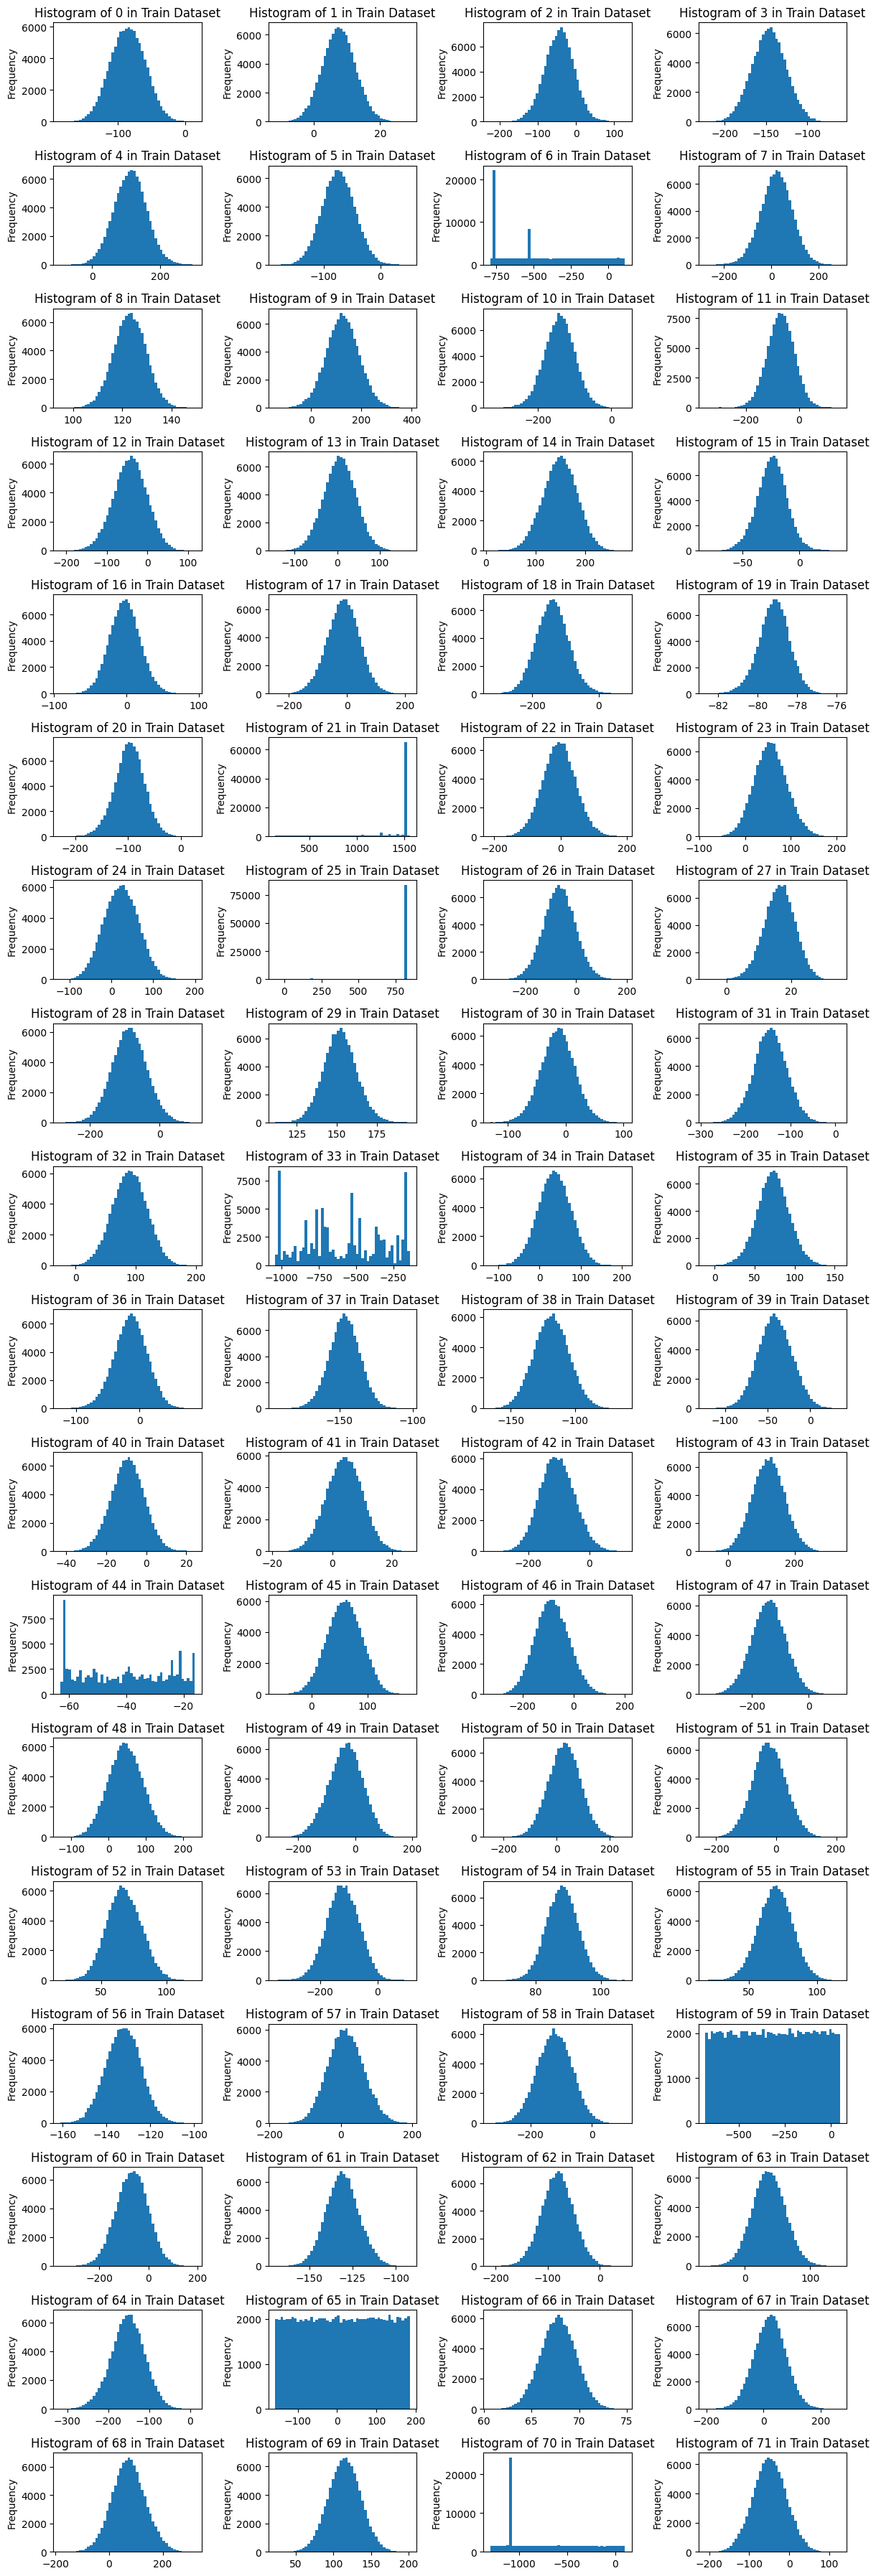

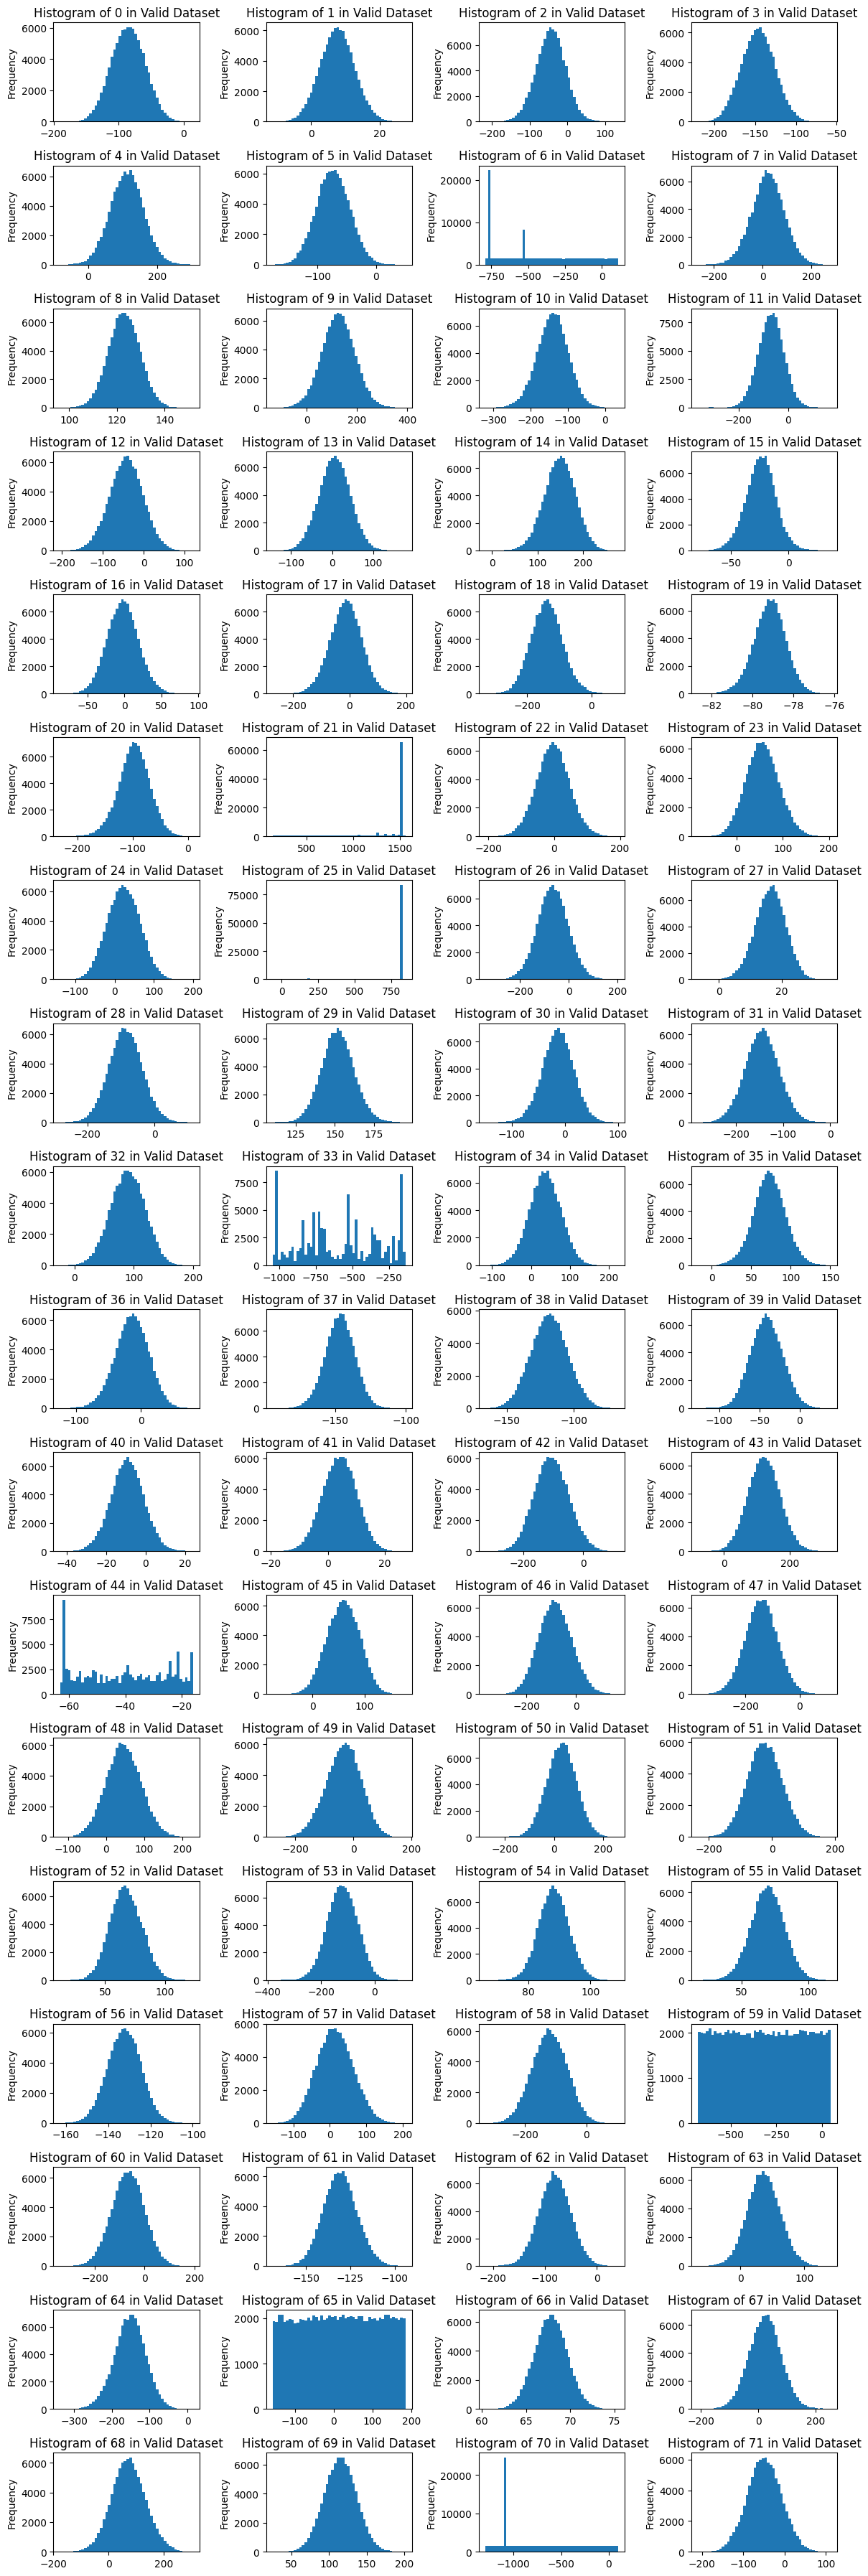

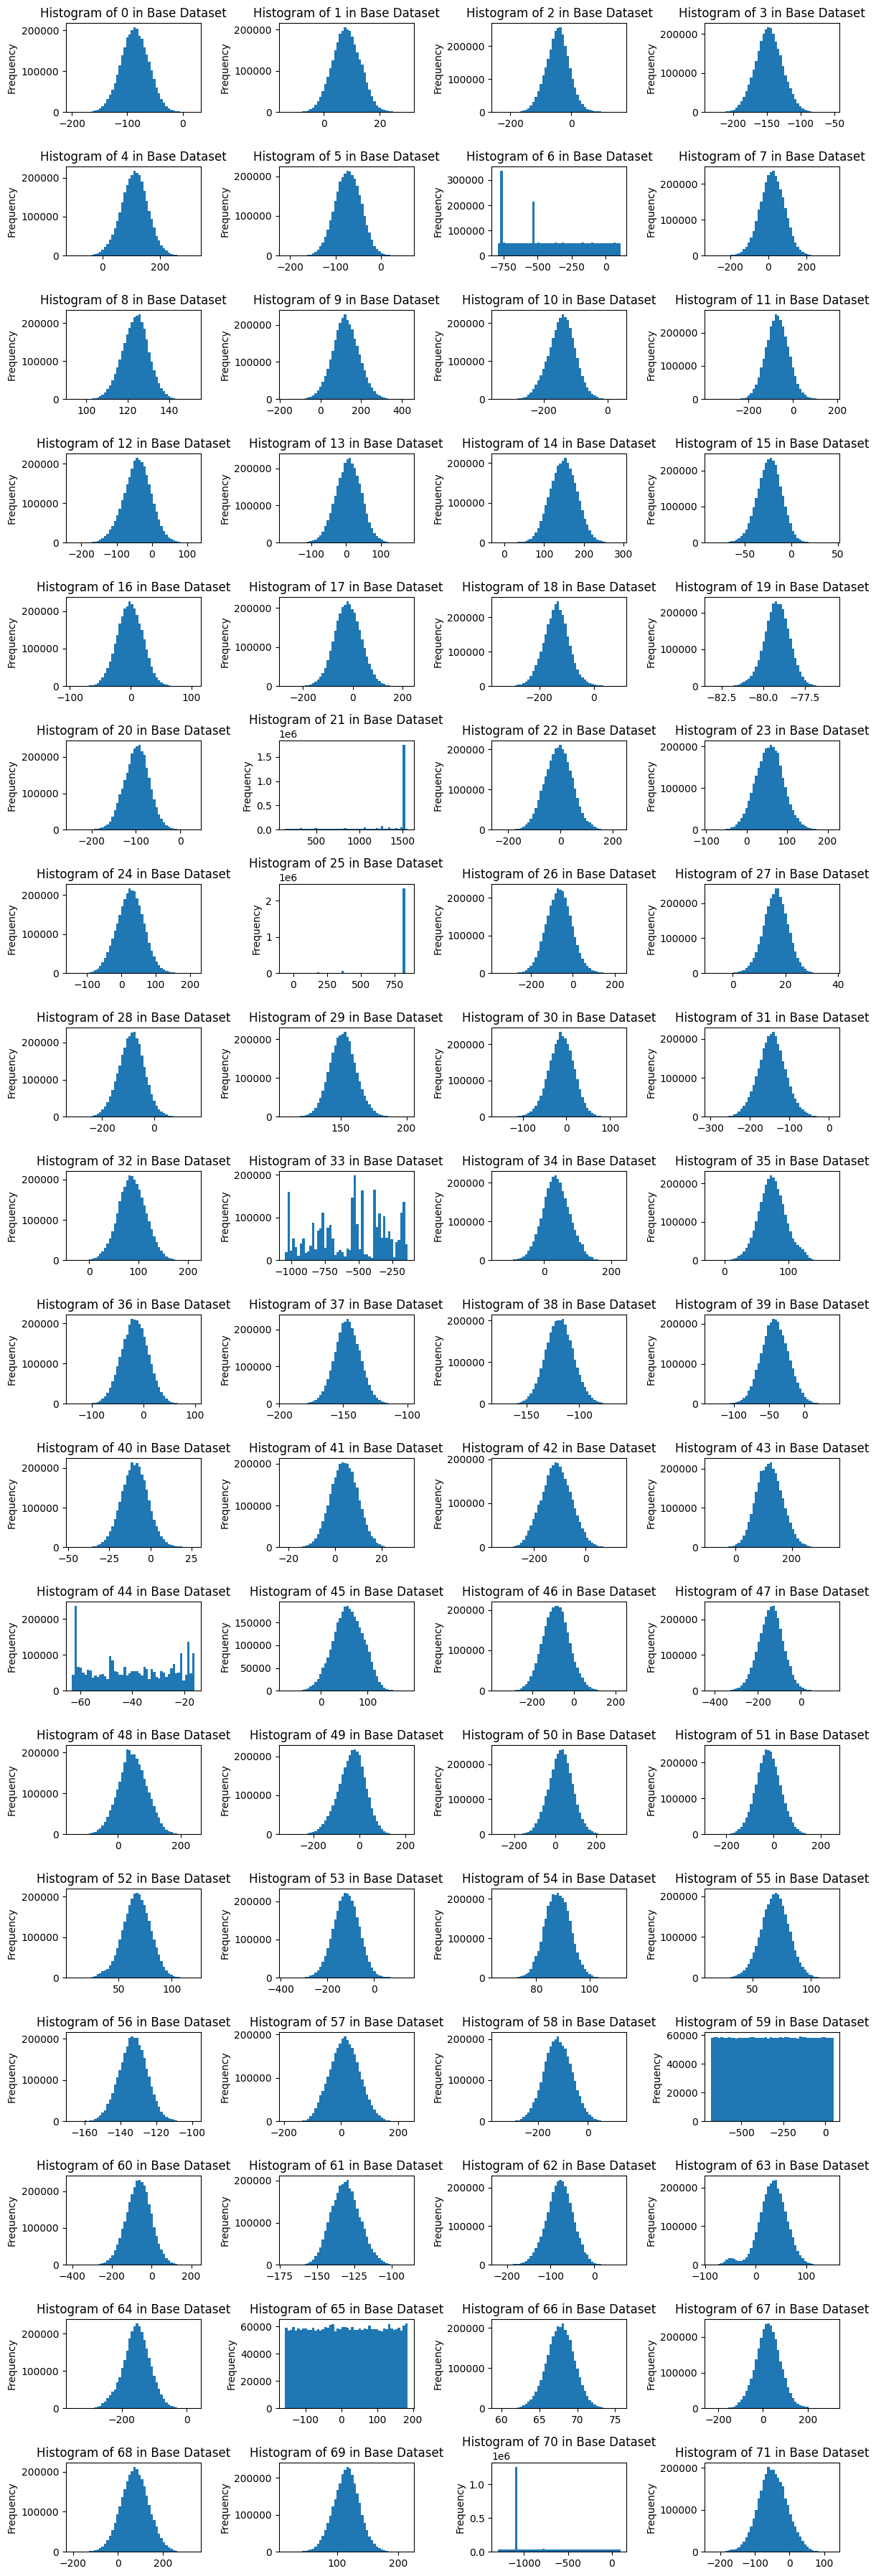

In [17]:
# Построим гистограммы для обучающей и валидационной выборок, а также для базового датасета
def get_numerical_columns_plots(df, name):
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    num_cols = 4  # Количество столбцов для отображения в одной строке
    num_rows = (len(numerical_columns) - 1) // num_cols + 1  # Рассчитать необходимое количество строк

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 2))

    for i, column in enumerate(numerical_columns):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]
        df[column].plot(kind='hist', bins=50, title=f'Histogram of {column} in {name}', ax=ax)
        # ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

get_numerical_columns_plots(train_df, 'Train Dataset')
get_numerical_columns_plots(validation_df, 'Valid Dataset')
get_numerical_columns_plots(base_df, 'Base Dataset')

### 3.1 Корреляция

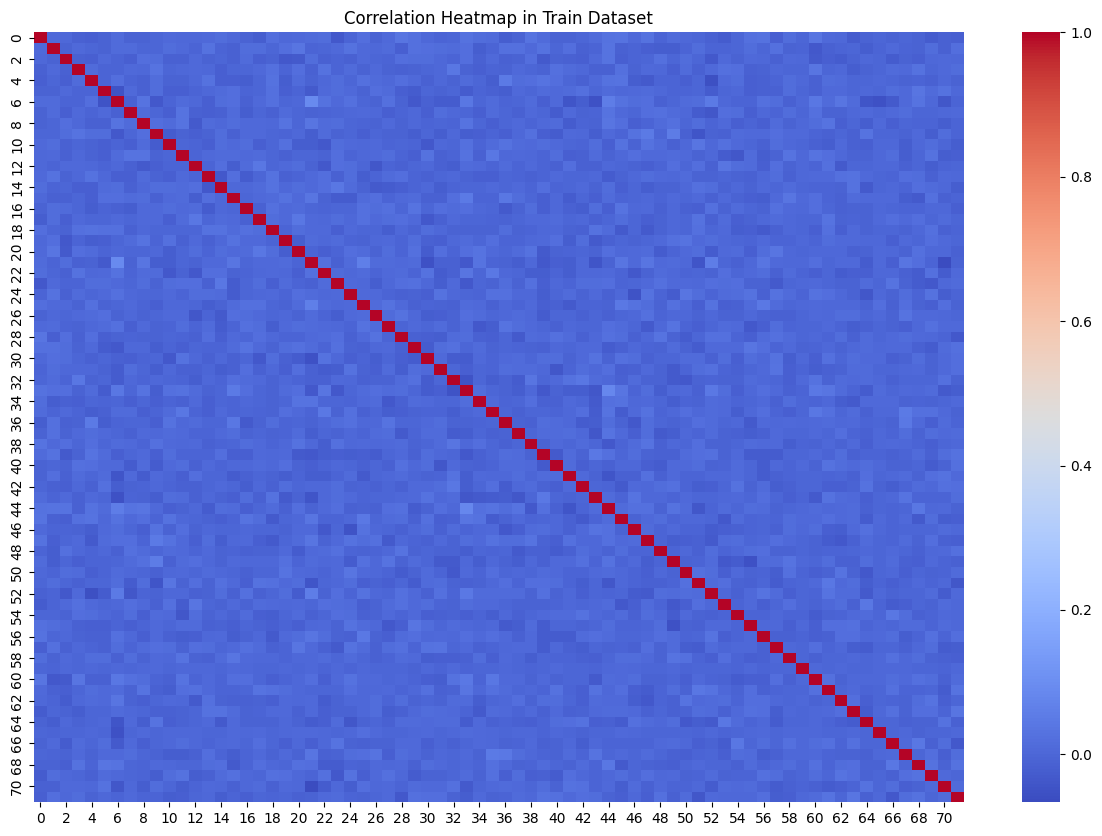

In [18]:
# Используем только числовые признаки для корреляции
numerical_train_df = train_df.select_dtypes(include=['float64', 'int64'])

# Рассчитаем корреляцию между числовыми признаками в тренировочном датасете
train_corr = numerical_train_df.corr()

# Построим тепловую карту для визуализации корреляций
plt.figure(figsize=(15, 10))
sns.heatmap(train_corr, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap in Train Dataset")
plt.show()

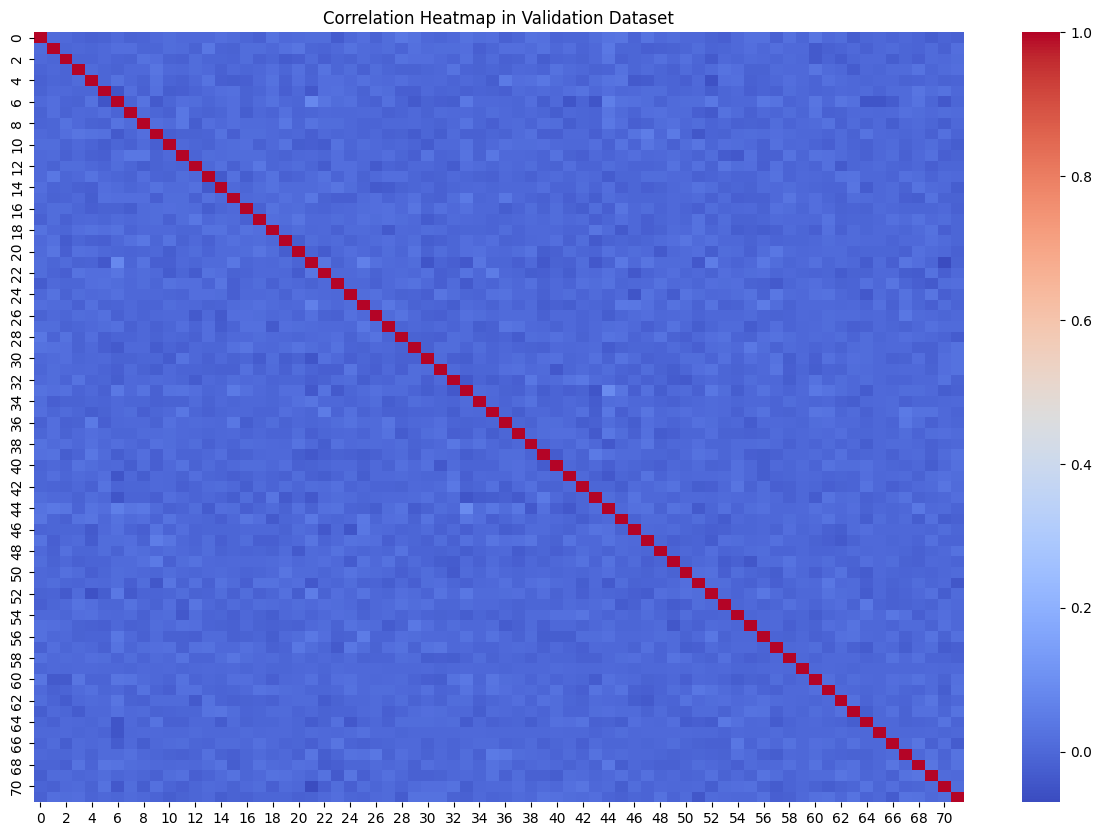

In [19]:
# Используем только числовые признаки для корреляции в валидационной выборке
numerical_validation_df = validation_df.select_dtypes(include=['float64', 'int64'])

# Рассчитаем корреляцию между числовыми признаками в валидационной выборке
validation_corr = numerical_validation_df.corr()

# Построим тепловую карту для визуализации корреляций в валидационной выборке
plt.figure(figsize=(15, 10))
sns.heatmap(validation_corr, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap in Validation Dataset")
plt.show()

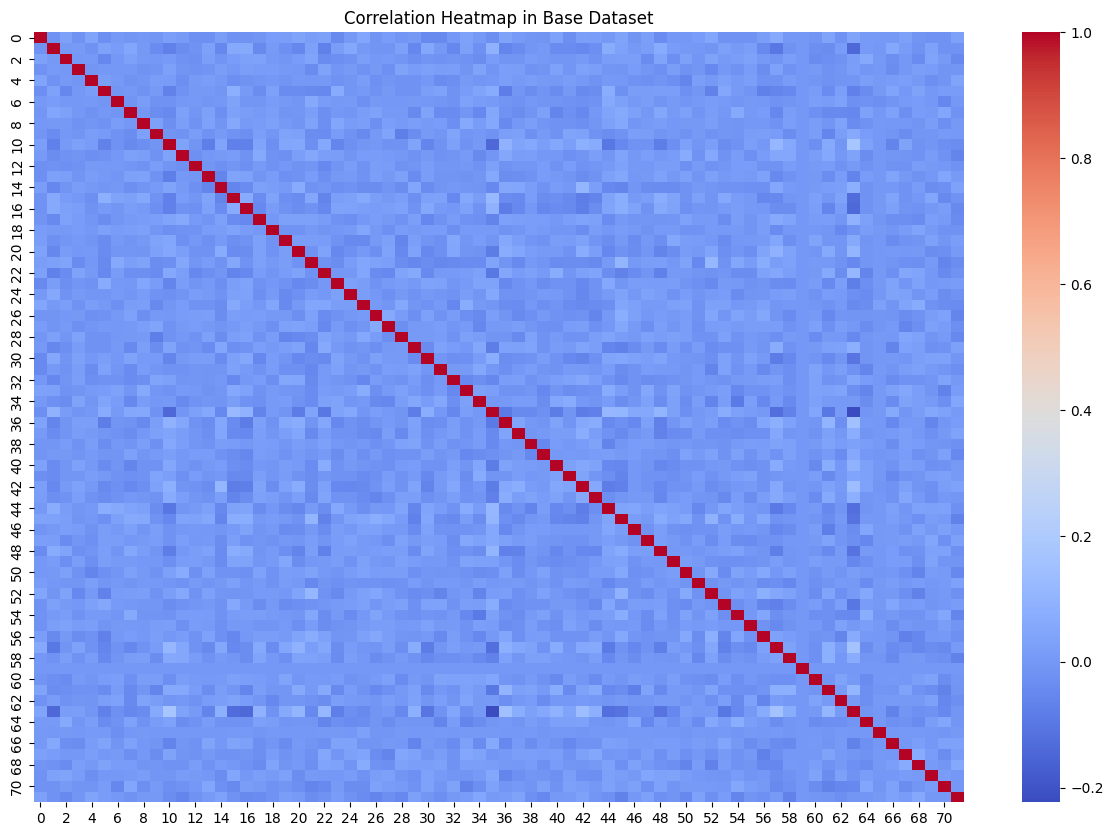

In [20]:
# пусто
# Используем только числовые признаки для корреляции в базовом датасете
numerical_base_df = base_df.select_dtypes(include=['float64', 'int64'])

# Рассчитаем корреляцию между числовыми признаками в базовом датасете
base_corr = numerical_base_df.corr()

# Построим тепловую карту для визуализации корреляций в базовом датасете
plt.figure(figsize=(15, 10))
sns.heatmap(base_corr, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap in Base Dataset")
plt.show()

### 3.2 Определим выбросы по каждому признаку каждого датасета

In [21]:
# определим выбросы по каждому признаку каждого датасета
def outliers_percentage_table(dataset):
    numerical_cols = dataset.select_dtypes(include=['float64', 'int64']).columns
    table_data = {'Column Name': [], 'Outliers Percentage': []}
    
    for col in numerical_cols:
        q1 = dataset[col].quantile(0.25)
        q3 = dataset[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers_percent = ((dataset[col] < lower_bound) | (dataset[col] > upper_bound)).mean() * 100
        table_data['Column Name'].append(col)
        table_data['Outliers Percentage'].append(round(outliers_percent, 2))
    
    outliers_table = pd.DataFrame(table_data)
    return outliers_table

# Применяем функцию к тренировочному датасету train_df
train_outliers_table = outliers_percentage_table(train_df)
print("Outliers Percentage Table for Train Dataset:")
print(train_outliers_table)

# Применяем функцию к валидационному датасету validation_df
validation_outliers_table = outliers_percentage_table(validation_df)
print("\nOutliers Percentage Table for Validation Dataset:")
print(validation_outliers_table)

# Применяем функцию к базовому датасету base_df
base_outliers_table = outliers_percentage_table(base_df)
print("\nOutliers Percentage Table for Base Dataset:")
print(base_outliers_table)

Outliers Percentage Table for Train Dataset:
   Column Name  Outliers Percentage
0            0                 0.38
1            1                 0.72
2            2                 1.10
3            3                 0.51
4            4                 0.72
..         ...                  ...
67          67                 0.86
68          68                 0.79
69          69                 0.67
70          70                 0.00
71          71                 0.50

[72 rows x 2 columns]

Outliers Percentage Table for Validation Dataset:
   Column Name  Outliers Percentage
0            0                 0.36
1            1                 0.62
2            2                 1.08
3            3                 0.44
4            4                 0.73
..         ...                  ...
67          67                 0.84
68          68                 0.75
69          69                 0.63
70          70                 0.00
71          71                 0.53

[72 rows x 2 col

In [22]:
# Создание итоговой таблицы с признаками с выбросами
def get_column_names(df, lower_bound, upper_bound):
    return ', '.join(df[(df['Outliers Percentage'] > lower_bound) & 
                        (df['Outliers Percentage'] <= upper_bound)]['Column Name'])

combined_outliers_table = pd.DataFrame({
    'Outliers Range': ['1-5%', '5-10%', '10-15%', '15%+'],
    'Train Column Names': [get_column_names(train_outliers_table, 1, 5),
                           get_column_names(train_outliers_table, 5, 10),
                           get_column_names(train_outliers_table, 10, 15),
                           get_column_names(train_outliers_table, 15, float('inf'))],
    'Validation Column Names': [get_column_names(validation_outliers_table, 1, 5),
                                get_column_names(validation_outliers_table, 5, 10),
                                get_column_names(validation_outliers_table, 10, 15),
                                get_column_names(validation_outliers_table, 15, float('inf'))],
    'Base Column Names': [get_column_names(base_outliers_table, 1, 5),
                          get_column_names(base_outliers_table, 5, 10),
                          get_column_names(base_outliers_table, 10, 15),
                          get_column_names(base_outliers_table, 15, float('inf'))]
})

print("\nOptimized Combined Outliers Percentage Table for Train, Validation and Base Datasets:")
display(combined_outliers_table)


Optimized Combined Outliers Percentage Table for Train, Validation and Base Datasets:


,Outliers Range,Train Column Names,Validation Column Names,Base Column Names
0,1-5%,"2, 15, 19, 20, 35","2, 15, 20","2, 18, 19, 63, 67, 69"
1,5-10%,,,21
2,10-15%,,,
3,15%+,"21, 25","21, 25",25


<div class="alert alert-info">
**Вывод**<br>
После изучения данных идентификации и анализа можно сделать следующие выводы:
1. Распределение признаков:
- Признаки имеют различный масштаб.
- Некоторые признаки имеют ненормальное распределение, в то время как другие приближены к нормальному.
- Некоторые признаки кажутся дискретными или категориальными из-за малого количества уникальных значений.

2. Корреляция признаков / мультиколлинеарность:
- Наблюдается отсутствие корреляции между признаками.

3. Выбросы / аномалии:
- Большинство признаков не имеют значительных выбросов.
- Средние значения близки к медиане.

Таким образом, данные в целом выглядят чистыми и готовыми для дальнейшего анализа и построения модели.

## **Повторная загрузка данных для проведения стандартизации**

Повторно загружаем датасеты, но указываем `index_col=0`, это означает, что первый столбец из CSV файла будет использован в качестве индекса (начиная с 0). В данном случае, данные из первого столбца (id) будут использоваться в качестве индексов (строк) DataFrame, но не будут рассматриваться как обычные столбцы данных.
Таким образом, параметр `index_col=0` позволяет установить определенный столбец данных как индекс DataFrame при загрузке данных из файла.

In [23]:
# Выгружаем датасет с базой данных
base_i_0 = pd.read_csv('/kaggle/input/product-matching-data/base.csv', index_col=0)
base_i_0.info()
print('')
# Выгружаем обучающий датасет
train_i_0 = pd.read_csv('/kaggle/input/product-matching-data/train.csv', index_col=0)
train_i_0.info()
print('')
# Выгружаем валидационный датасет
valid_i_0 = pd.read_csv('/kaggle/input/product-matching-data/validation.csv', index_col=0)
valid_i_0.info()
print('')
# Выгружаем правильные ответы к валидационному датасету
valid_ans_i_0 = pd.read_csv('/kaggle/input/product-matching-data/validation_answer.csv', index_col=0)
valid_ans_i_0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


## 4 Удаление столбцов с ненормальным распределением

Из проведенного ранее анализа данных было выявлено, что столбцы-признаки 6, 21, 25, 33, 44, 59, 65, 70 имеют ненормальное распределение. Кроме того, столбцы с названием 21 и 25 обладают большим количеством выбросов в данных. На основании этих результатов рекомендуется исключить данные признаки из анализа, так как они могут оказывать негативное влияние на качество модели.

Также в датасете были обнаружены столбцы-признаки под номерами 2, 18, 19, 63, 67, 69, которые содержат незначительные выбросы, однако распределение данных в этих столбцах не вызывает серьезных подозрений. Поэтому исключение этих признаков из анализа не является обязательным.

Такое удаление признаков поможет улучшить качество модели и повысить метрику на обучающей и валидационной выборках. Проведенные эксперименты были записаны в сводную таблицу.

In [24]:
exclude_features = [
    ['-','-','25','-','-','-','-','-','-','66.69','66.501'],
    ['6','21','25','33','44','59','-','65','70','71.06','70.965'],
    ['6','21','25','33','44','59','-','65','-','71.424','71.235'],
    ['-','21','25','33','44','59','-','65','70','71.501','71.383'],
    ['-','21','25','33','44','59','-','65','-','71.904','71.765'],
    ['-','21','25','33','44','59','63','65','-','71.845','71.731'],
    ['-','21','25','33','44','-','-','65','-','70.741','70.629']
]

# Переименование колонок
columns = {
    'Column_1': 'Исключаемый признак 1',
    'Column_2': 'Исключаемый признак 2',
    'Column_3': 'Исключаемый признак 3',
    'Column_4': 'Исключаемый признак 4',
    'Column_5': 'Исключаемый признак 5',
    'Column_6': 'Исключаемый признак 6',
    'Column_7': 'Исключаемый признак 7',
    'Column_8': 'Исключаемый признак 8',
    'Column_9': 'Исключаемый признак 9',
    'Column_10': 'accuracy@5 на обуч. выборке',
    'Column_11': 'accuracy@5 на валид. выборке'
}

df = pd.DataFrame(exclude_features, columns=columns.keys())
df = df.rename(columns=columns)

df_styled = df.style.set_properties(**{'text-align': 'center'}).set_table_styles([{
    'selector': 'th',
    'props': [('background-color', 'lightgrey')]
}])

df_styled

,Исключаемый признак 1,Исключаемый признак 2,Исключаемый признак 3,Исключаемый признак 4,Исключаемый признак 5,Исключаемый признак 6,Исключаемый признак 7,Исключаемый признак 8,Исключаемый признак 9,accuracy@5 на обуч. выборке,accuracy@5 на валид. выборке
0,-,-,25,-,-,-,-,-,-,66.69,66.501
1,6,21,25,33,44,59,-,65,70,71.06,70.965
2,6,21,25,33,44,59,-,65,-,71.424,71.235
3,-,21,25,33,44,59,-,65,70,71.501,71.383
4,-,21,25,33,44,59,-,65,-,71.904,71.765
5,-,21,25,33,44,59,63,65,-,71.845,71.731
6,-,21,25,33,44,-,-,65,-,70.741,70.629


Данная таблица представляет собой результаты исследования влияния исключения различных признаков на метрику accuracy@5 на обучающей и валидационной выборках. Каждая строка таблицы соответствует определенному эксперименту, в котором были исключены определенные признаки (обозначенные как "Исключаемый признак 1" до "Исключаемый признак 9"), после чего были измерены значения метрики accuracy@5 на обучающей и валидационной выборках.

Цель данного исследования заключается в определении того, какое исключение признаков приводит к наиболее высокому показателю метрики. По результатам исследования можно сделать вывод о том, какие признаки являются наименее информативными или дублирующими другие признаки, и их исключение может привести к улучшению качества модели.

Таким образом, данная таблица представляет собой наглядное исследование по определению оптимального набора признаков для достижения максимального показателя метрики accuracy@5 на обучающей и валидационной выборках.

**В качестве итога принимаем к удалению столбцы- признаки ['21', '25', '33', '44', '59', '65']**

### **Удаление выбранных столбцов с ненормальным распределением**

In [25]:
list_to_delete = ['21', '25', '33', '44', '59', '65']

# Удаляем выбранные столбцы из выбранных датафреймов
base = base_i_0.drop(list_to_delete, axis=1, errors='ignore')
train = train_i_0.drop(list_to_delete, axis=1, errors='ignore')
valid = valid_i_0.drop(list_to_delete, axis=1, errors='ignore')
# valid_ans = valid_ans_i_0.drop(list_to_delete, axis=1, errors='ignore')

## 5 Преобразование данных

**Стандартизация**

Стандартизация данных - это процесс преобразования значений признаков таким образом, чтобы среднее значение стало равным 0, а стандартное отклонение равно 1. Это помогает моделям машинного обучения лучше работать, упрощая процесс оптимизации и повышая точность результатов.
Этот процесс поможет обеспечить однообразие масштабов признаков в датафреймах, что важно для многих моделей машинного обучения, особенно для моделей, которые чувствительны к различиям в масштабе признаков, например, методы опорных векторов (SVM) или градиентный спуск.

In [26]:
# Преобразование данных с помощью стандартизации для всех датафреймов
start_time = time.time()

# Преобразуем данные с помощью стандартизации для всех трех датафреймов
for i in base.columns:
    mean = base[i].mean()
    std = base[i].std()
    train[i] = (train[i] - mean) / std
    valid[i] = (valid[i] - mean) / std
    base[i] = (base[i] - mean) / std

standardization_time = time.time() - start_time
print(f"Время стандартизации: {standardization_time:.2f} секунд")

Время стандартизации: 2.94 секунд


## 6 Создание индекса

**Создадим индекс для поиска ближайших соседей с использованием библиотеки Faiss**

In [27]:
# **Создание индекса**
# Создаем пустой индекс
dims = base.shape[1]
n_cells = 500
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

start_time = time.time()
# Обучаем индекс
idx_l2.train(np.ascontiguousarray(base.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))
training_time = time.time() - start_time
print(f"Время обучения модели Faiss: {training_time:.2f} секунд")

Время обучения модели Faiss: 7.63 секунд


### 6.1 Сохраним обученную модель Faiss в файле для использования в дальнейшем

In [28]:
# Сохраняем модель в файл
with open('faiss_index.pkl', 'wb') as f:
    pickle.dump(idx_l2, f)

# Создаем словарь с порядковыми номерами индексов и индексом в base
base_index = {k: v for k, v in enumerate(base.index.to_list())}

# Сохраняем полученный словарь в отдельный файл
with open('base_index.txt', 'w') as f:
     f.write(json.dumps(base_index))

## 7 Обучение и тестирование модели

**Определение целевого признака**

Разделим обучающую выборку на целевые значения (targets) и признаки, удаляя при этом целевой столбец из признаков для подготовки данных к обучению модели машинного обучения.

In [29]:
targets = train["Target"]
train.drop("Target", axis=1, inplace=True)

### 7.1 Выполнение поиска ближайших соседей и вывод метрики accuracy@5

In [30]:
# На обучающей выборке
start_time = time.time()

idx_l2.nprobe = 300
r, idx = idx_l2.search(np.ascontiguousarray(train.values).astype('float32'), 5)

training_accuracy_time = time.time() - start_time
print(f"Время вычисления на обучающей выборке: {training_accuracy_time:.2f} секунд")

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print("Метрика accuracy@5 на обучающей выборке:", 100 * acc / len(idx))

Время вычисления на обучающей выборке: 2016.50 секунд
Метрика accuracy@5 на обучающей выборке: 71.904


In [31]:
# На валидационной выборке
start_time = time.time()

idx_l2.nprobe = 300
r_v, idx_v = idx_l2.search(np.ascontiguousarray(valid.values).astype('float32'), 5)

validation_accuracy_time = time.time() - start_time
print(f"Время вычисления на валидационной выборке: {validation_accuracy_time:.2f} секунд")

acc_v = 0
for v, el_v in zip(valid_ans_i_0['Expected'].values.tolist(), idx_v.tolist()):
    acc_v += int(v in [base_index[r_v] for r_v in el_v])

print("Метрика accuracy@5 на валидационной выборке:", 100 * acc_v / len(idx_v))

Время вычисления на валидационной выборке: 2006.17 секунд
Метрика accuracy@5 на валидационной выборке: 71.765


## 8 Деплой

Деплой REST API сервиса с использованием обученной модели позволит интегрировать функциональность подбора наиболее подходящих товаров на основе входных данных в различные приложения и платформы. Это может быть полезно для интернет-магазинов, рекомендательных систем, аналитических платформ и других проектов, где требуется предлагать пользователям наиболее релевантные и интересные товары. Пользователи смогут получить персонализированные рекомендации, что может увеличить их удовлетворенность, уровень конверсии и общую пользовательскую ценность.

In [38]:
# import sys
print("Принудительная остановка выполнения кода.")
sys.exit()

Принудительная остановка выполнения кода.


SystemExit: 

In [33]:
# Создаем Flask приложение
app = Flask(__name__)

# Роут для предсказания наиболее подходящих товаров
@app.route('/predict', methods=['POST'])
def predict():
    # Получаем данные от пользователя
    data = request.get_json()
    # Преобразуем входные данные в DataFrame
    input_data = pd.DataFrame(data["features"], index=[0])
    
    # Получаем индексы ближайших соседей
    idx_l2.nprobe = 300
    _, idx = idx_l2.search(input_data.astype('float32').values, 5)
    
    # Находим соответствующие товары по индексам
    recommended_products = [base_index[i] for i in idx[0]]
    
    return jsonify({'recommended_products': recommended_products})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1042, in launch_instance
    app.initialize(argv)
  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 113, in inner
    return method(app, *args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 654, in initialize
    self.init_sockets()
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 331, in init_sockets
    self.shell_port = self._bind_socket(self.shell_socket, self.shell_port)
  File "/opt/conda/lib/python3.10/site-packages/

SystemExit: 1